In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.vision.all import *
from self_supervised.layers import *
import sklearn

In [3]:
datapath = Path("../data/stanford-dogs-dataset/")

In [4]:
train_df = pd.read_csv(datapath/'train.csv')
test_df = pd.read_csv(datapath/'test.csv')
sample_df = pd.read_csv(datapath/'sample_train.csv')

In [5]:
train_df.shape, test_df.shape, sample_df.shape

((12000, 2), (8580, 2), (6000, 3))

In [6]:
# train_df.head()
# test_df.head()
# sample_df.head()

### Dataset

In [7]:
def read_image(filename): return PILImage.create(datapath/'images/Images'/filename)
def read_image_size(filename): return PILImage.create(datapath/'images/Images'/filename).shape

In [8]:
FAST = False

In [9]:
if FAST:
    filenames = sample_df['filename'].values
    labels = sample_df['label'].values
    fn2label = dict(zip(filenames, labels))
else:
    filenames = train_df['filenames'].values
    labels = train_df['labels'].values
    fn2label = dict(zip(filenames, labels))

In [10]:
def read_label(filename): return fn2label[filename]

In [11]:
valid_filenames = sample_df.query("split == 'valid'")['filename'].values

In [12]:
# size,bs = 384,32

# tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
#         [read_label, Categorize()]]

# valid_splitter = lambda o: True if o in valid_filenames else False 
# dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

# batch_augs = aug_transforms()
# # batch_augs = []

# stats = imagenet_stats

# batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
# dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [13]:
# len(dls.train_ds), len(dls.valid_ds)

In [14]:
# dls.show_batch()

### Modifications on ViT

In [15]:
from utils.custom_vit import *

In [16]:
# # timm vit _encoder
# arch = "vit_base_patch16_384"
# _encoder = create_encoder(arch, pretrained=True, n_in=3)

In [17]:
# # custom vit encoder with timm weights
# encoder = VisionTransformer(img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12)
# encoder.head = Identity()
# encoder.load_state_dict(_encoder.state_dict());

In [18]:
# # grad checkpointing
# encoder = CheckpointVisionTransformer(encoder, 12)

In [19]:
# # 1) Change Stride Size

# patch_size,stride_size = 16,16

# # new_patch_embed = PatchEmbed(size, patch_size, stride_size)
# # new_patch_embed.proj.weight.data = encoder.vit_model.patch_embed.proj.weight.data
# # new_patch_embed.proj.bias.data = encoder.vit_model.patch_embed.proj.bias.data
# # encoder.vit_model.patch_embed = new_patch_embed

# # 2) Interpolate Position Embeddings to new Number of Patches

# # num_patches = ((size - patch_size + stride_size) // stride_size)**2 + 1

# # pos_embed_data = encoder.vit_model.pos_embed.data
# # new_pos_embed_data = F.interpolate(pos_embed_data[None, ...], 
# #                                    size=[num_patches, pos_embed_data.size(-1)], 
# #                                    mode='nearest')[0]
# # encoder.vit_model.pos_embed.data = new_pos_embed_data

3) Create Model

In [20]:
# with torch.no_grad():
#     out, attn_wgts = encoder(torch.randn(2,3,size,size))
#     nf = out.size(1)
# classifier = create_cls_module(nf, dls.c, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

In [21]:
# class FGVCModel(Module):
#     def __init__(self, encoder, classifier, return_attn_wgts=False):
#         self.encoder = encoder
#         self.classifier = classifier
#         self.return_attn_wgts = return_attn_wgts
        
#     def forward(self, x):
#         cls_token,attn_wgts = self.encoder(x)
#         if self.return_attn_wgts: return self.classifier(cls_token), attn_wgts, cls_token
#         else:                     return self.classifier(cls_token)  

In [22]:
# model = FGVCModel(encoder, classifier)

In [23]:
# attn_wgts[0].shape

In [24]:
# model.classifier

In [25]:
# # def model_splitter(m): return L(m[0], m[1]).map(params)
# def model_splitter(m): return L(m.encoder, m.classifier).map(params)

In [25]:
# cbs = []
# # if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]
# learn = Learner(dls, model, opt_func=ranger, cbs=cbs, metrics=[accuracy], splitter=model_splitter,
#                 loss_func=LabelSmoothingCrossEntropyFlat(0.1))
# learn.to_fp16();

### Train for Warmup

In [26]:
# learn.lr_find()

In [27]:
# epochs = 2

# lr = 3e-3
# learn.freeze()
# learn.fit_one_cycle(epochs, lr_max=(lr), pct_start=0.5)

# lr /= 3 
# learn.unfreeze()
# learn.fit_one_cycle(int(epochs**2), lr_max=slice(lr/100, lr), pct_start=0.5)

# learn.save(f"{arch}_stride_{stride_size}_imsize_{size}")

In [28]:
# learn.load(f"{arch}_stride_{stride_size}_imsize_384");

In [29]:
# learn.validate()

In [30]:
# pretrained_vit_encoder = learn.model.encoder.vit_model

In [31]:
# del learn, dls, model
# torch.cuda.empty_cache()

### Multi Crop Dataset : 1 x (384 px whole image) + 2 x (448 px -> 112 px crops)

In [32]:
from utils.attention import *
from utils.pooling_nms_crops import *

In [33]:
size,bs = 448,16

tfms = [[read_image, ToTensor, RandomResizedCrop(size, min_scale=.75)], 
        [read_label, Categorize()]]

valid_splitter = lambda o: True if o in valid_filenames else False 
dsets = Datasets(filenames, tfms=tfms, splits=FuncSplitter(valid_splitter)(filenames))

batch_augs = aug_transforms()
# batch_augs = []

stats = imagenet_stats

batch_tfms = [IntToFloatTensor] + batch_augs + [Normalize.from_stats(*stats)]
dls = dsets.dataloaders(bs=bs, after_batch=batch_tfms)

In [34]:
from torch.utils.checkpoint import checkpoint
class FullImageEncoder(Module):
    "Encoder which takes whole image input then outputs attention weights + layer features"
    def __init__(self, pretrained_vit_encoder, nblocks=12, checkpoint_nchunks=2, return_attn_wgts=True):
                
        # initialize params with warm up model
        self.patch_embed = pretrained_vit_encoder.patch_embed
        self.cls_token = pretrained_vit_encoder.cls_token
        self.pos_embed = pretrained_vit_encoder.pos_embed
        self.pos_drop = pretrained_vit_encoder.pos_drop
        
        # until layer n-1, can be changed (memory trade-off)
        self.blocks = pretrained_vit_encoder.blocks[:nblocks]        
        
        # not needed now
#         self.norm = pretrained_vit_encoder.norm
        
        # gradient checkpointing
        self.checkpoint_nchunks = checkpoint_nchunks
        
        self.return_attn_wgts = return_attn_wgts
         
    def forward_features(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)

        cls_tokens = self.cls_token.expand(B, -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        # collect attn_wgts from all layers
        attn_wgts = []
        if self.return_attn_wgts:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,attn_wgt = checkpoint(blk, x)
                else:                         x,attn_wgt = blk(x)
                attn_wgts.append(attn_wgt)
            return x,attn_wgts
        
        else:
            for i,blk in enumerate(self.blocks):
                if i<self.checkpoint_nchunks: x,_ = checkpoint(blk, x)
                else:                         x,_ = blk(x)
            return x
        
    def forward(self, x):
        return self.forward_features(x)

#### get attention maps 

In [35]:
# full_image_encoder = FullImageEncoder(pretrained_vit_encoder, nblocks=12, checkpoint_nchunks=12).cuda()

In [36]:
# xb_448, yb = dls.one_batch()

In [37]:
# xb_384 = F.interpolate(xb_448, size=(384,384))

In [38]:
# xb_448_decoded = dls.after_batch.decode(xb_448)

In [39]:
# x_full, attn_wgts = full_image_encoder(xb_384)

In [40]:
# attention_maps = to_detach(generate_batch_attention_maps(attn_wgts, None, mode=None))

#### get crop bounding boxes

In [41]:
# source_sz = 384  # source image size in px that attention maps were generated
# targ_sz = 448 # target image size in px that crops will be taken

In [42]:
# batch_final_resized_coords = generate_batch_crops(attention_maps,source_sz,targ_sz,targ_bbox_sz=144,num_bboxes=2,nms_thresh=0.1)

In [43]:
# bs = len(xb_448_decoded)
# fig, axes = plt.subplots(bs, 4, figsize=(4*4,bs*4))

# for i,(coords,ax) in enumerate(zip(batch_final_resized_coords,axes)):
#     coord1, coord2 = coords.astype(int)
    
#     im = xb_448_decoded[i]
#     show_image(im, ax=ax[0])
#     show_image(attention_maps[i], ax=ax[1])
#     show_image(im[:, coord1[0]:coord1[2], coord1[1]:coord1[3]], ax=ax[2])
#     show_image(im[:, coord2[0]:coord2[2], coord2[1]:coord2[3]], ax=ax[3])

### Model

In [44]:
# # common shared encoder
# full_image_encoder = FullImageEncoder(pretrained_vit_encoder, nblocks=12, checkpoint_nchunks=12).cuda()

In [46]:
# crop_image_encoder = deepcopy(full_image_encoder).cuda()
# crop_image_encoder.return_attn_wgts = False

# # interpolate pos embed from 384 px -> 112 px
# num_patches = 197
# pos_embed_data = crop_image_encoder.pos_embed.data
# new_pos_embed_data = F.interpolate(pos_embed_data[None, ...], size=[num_patches, pos_embed_data.size(-1)])[0]
# crop_image_encoder.pos_embed.data = new_pos_embed_data

In [47]:
# final_block = Block(dim=768,num_heads=12,mlp_ratio=4.,qkv_bias=True,qk_scale=None)
# norm = partial(nn.LayerNorm, eps=1e-6)(768)
# classifier = create_cls_module(768, 120, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

In [48]:
# xb_448,yb = dls.one_batch()

In [49]:
# xb_448.shape

In [50]:
# xb_384 = F.interpolate(xb_448, size=(384,384))
# x_full, attn_wgts = full_image_encoder(xb_384)

In [51]:
# attention_maps = generate_batch_attention_maps(attn_wgts, None, mode=None).detach()

In [52]:
# batch_crop_bboxes = generate_batch_crops(attention_maps.cpu(),
#                                          source_sz=384,
#                                          targ_sz=448,
#                                          targ_bbox_sz=224,
#                                          num_bboxes=2, 
#                                          nms_thresh=0.2)

In [53]:
# xb_crops1, xb_crops2 = [], []
# for bboxes,img in zip(batch_crop_bboxes, xb_448):
#     minr, minc, maxr, maxc = bboxes[0]
#     crop1 = img[:, minr:maxr,minc:maxc]
#     minr, minc, maxr, maxc = bboxes[1]
#     crop2 = img[:, minr:maxr,minc:maxc]
#     xb_crops1.append(crop1)
#     xb_crops2.append(crop2)

In [54]:
# xb_crops1 = torch.stack(xb_crops1)
# xb_crops2 = torch.stack(xb_crops2)

In [55]:
# xb_crops1 = F.interpolate(xb_crops1, size=(384,384))
# xb_crops2 = F.interpolate(xb_crops2, size=(384,384))

In [56]:
# xb_384.shape, xb_crops1.shape, xb_crops2.shape

In [57]:
# full_image_encoder.return_attn_wgts = False
# x_crop1 = full_image_encoder(xb_crops1)
# x_crop2 = full_image_encoder(xb_crops2)

In [58]:
# x_full.shape, x_crop1.shape, x_crop2.shape

In [59]:
# # final_block = Block(dim=768,num_heads=12,mlp_ratio=4.,qkv_bias=True,qk_scale=None).to(default_device())
# norm = partial(nn.LayerNorm, eps=1e-6)(768).to(default_device())
# classifier = create_cls_module(768, 120, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.).to(default_device())

In [60]:
# x = torch.cat([x_full, x_crop1, x_crop2], dim=1)
# x = norm(x)[:,0]
# # x,_ = final_block(x)
# # x = norm(x)[:,0]
# out_concat = classifier(x)

In [61]:
# out_concat.shape

In [62]:
448

448

In [45]:
class MultiCropViTV2(Module):
    "Multi Size Multi Crop ViT Model"
    def __init__(self, encoder):
        
        self.full_image_encoder = FullImageEncoder(encoder, nblocks=12, checkpoint_nchunks=12)
#         self.final_block = Block(dim=768,num_heads=12,mlp_ratio=4.,qkv_bias=True,qk_scale=None)
        self.norm = partial(nn.LayerNorm, eps=1e-6)(768)
        self.classifier = create_cls_module(768*5, 120, lin_ftrs=[768], use_bn=False, first_bn=False, ps=0.)

        
    def forward(self, xb_448):
        
        # full image features and attention maps
        xb_384 = F.interpolate(xb_448, size=(384,384))
        self.full_image_encoder.return_attn_wgts = True
        x_full, attn_wgts = self.full_image_encoder(xb_384)

        # attention map bboxes
        attention_maps = generate_batch_attention_maps(attn_wgts, None, mode=None).detach()
        
        # 2 large crops - 224 / 448 (50% area)
        batch_crop_bboxes = generate_batch_crops(attention_maps.cpu().float(),
                                                 source_sz=384,
                                                 targ_sz=448,
                                                 targ_bbox_sz=224,
                                                 num_bboxes=2, 
                                                 nms_thresh=0.2)
        xb_large_crops1, xb_large_crops2 = [],[]
        for bboxes, img in zip(batch_crop_bboxes, xb_448):
            minr, minc, maxr, maxc = bboxes[0]
            crop = img[:, minr:maxr,minc:maxc]
            xb_large_crops1.append(crop)
            
            minr, minc, maxr, maxc = bboxes[1]
            crop = img[:, minr:maxr,minc:maxc]
            xb_large_crops2.append(crop)

            
        # 2 small crops - 112 / 448 (25% area)
        batch_crop_bboxes = generate_batch_crops(attention_maps.cpu().float(),
                                                 source_sz=384,
                                                 targ_sz=448,
                                                 targ_bbox_sz=112,
                                                 num_bboxes=2, 
                                                 nms_thresh=0.1)
        xb_small_crops1, xb_small_crops2 = [], []
        for bboxes, img in zip(batch_crop_bboxes, xb_448):
            minr, minc, maxr, maxc = bboxes[0]
            crop = img[:, minr:maxr,minc:maxc]
            xb_small_crops1.append(crop)
            
            minr, minc, maxr, maxc = bboxes[1]
            crop = img[:, minr:maxr,minc:maxc]
            xb_small_crops2.append(crop)
            
        
        # resize crop images
        xb_large_crops1 = F.interpolate(torch.stack(xb_large_crops1), size=(384,384))
        xb_large_crops2 = F.interpolate(torch.stack(xb_large_crops2), size=(384,384))
        xb_small_crops1 = F.interpolate(torch.stack(xb_small_crops1), size=(384,384))
        xb_small_crops2 = F.interpolate(torch.stack(xb_small_crops2), size=(384,384))
        
        # save for visualization
        i = np.random.choice(range(len(xb_448)))
        self.random_images = to_detach([xb_448[i].clone(),
                                        xb_large_crops1[i].clone().float(), 
                                        xb_large_crops2[i].clone().float(),
                                        xb_small_crops1[i].clone().float(), 
                                        xb_small_crops2[i].clone().float()
                                       ])
                
        # crop features
        self.full_image_encoder.return_attn_wgts = False
        x_large_crop1 = self.full_image_encoder(xb_large_crops1)
        x_large_crop2 = self.full_image_encoder(xb_large_crops2)
        x_small_crop1 = self.full_image_encoder(xb_small_crops1)
        x_small_crop2 = self.full_image_encoder(xb_small_crops2)
        

        x = torch.cat([self.norm(x_full)[:,0],
                       self.norm(x_large_crop1)[:,0],
                       self.norm(x_large_crop2)[:,0],
                       self.norm(x_small_crop1)[:,0],
                       self.norm(x_small_crop2)[:,0]], dim=-1)
        

        out_concat = self.classifier(x)
        return out_concat

In [46]:
class CollectImages(Callback):
    run_train,run_valid=True,False
    def __init__(self):
        self.images = []
    
    def after_pred(self):
        if self.iter % 10 == 0:
            self.images.append([TensorImage(o) for o in self.learn.model.random_images])

### Train

In [47]:
# torch.autograd.set_detect_anomaly(True)

In [52]:
def model_splitter(m): return L(m.full_image_encoder, 
                                m.norm,
                                m.classifier).map(params)

In [53]:
# class MultiCropLoss(Module):
#     def __init__(self, lf):
#         self.lf = lf
    
#     def forward(self, preds, targs):
#         out_concat, (out_full, out_crop1, out_crop2) = preds
#         self.loss_concat = self.lf(out_concat, targs)
#         self.loss_full = self.lf(out_full, targs)
#         self.loss_crop1 = self.lf(out_crop1, targs)
#         self.loss_crop2 = self.lf(out_crop2, targs)
        
# #         return self.loss_concat+self.loss_full+self.loss_crop1+self.loss_crop2
# #         return self.loss_concat+self.loss_full+self.loss_crop1+self.loss_crop2
# #         return self.loss_crop1+self.loss_crop2
#         return self.loss_crop1

# def concat_accuracy(preds, targs): return accuracy(preds[0],    targs)
# def full_accuracy(preds, targs):   return accuracy(preds[1][0], targs)
# def crop1_accuracy(preds, targs):  return accuracy(preds[1][1], targs)
# def crop2_accuracy(preds, targs):  return accuracy(preds[1][2], targs)

In [54]:
# loss_metrics = LossMetrics("loss_concat,loss_full,loss_crop1,loss_crop2")
# metrics = loss_metrics + [concat_accuracy, full_accuracy, crop1_accuracy, crop2_accuracy]

In [55]:
# timm vit _encoder
arch = "vit_base_patch16_384"
_encoder = create_encoder(arch, pretrained=True, n_in=3)

# custom vit encoder with timm weights
encoder = VisionTransformer(img_size=384, patch_size=16, embed_dim=768, depth=12, num_heads=12)
encoder.head = Identity()
encoder.load_state_dict(_encoder.state_dict());

In [56]:
metrics = accuracy
loss_func = LabelSmoothingCrossEntropyFlat(0.1)

In [57]:
mcvit_model = MultiCropViTV2(encoder)

In [58]:
cbs = [CollectImages()]
learn = Learner(dls, mcvit_model, opt_func=ranger, cbs=cbs, metrics=metrics, loss_func=loss_func, splitter=model_splitter)
learn.to_fp16();

In [59]:
epochs = 2
lr = 3e-3

In [60]:
# learn.freeze_to(1)
# learn.fit_one_cycle(epochs, lr_max=(lr), pct_start=0.5)

In [ ]:
lr /= 3 
learn.unfreeze()
learn.fit_one_cycle(int(epochs**2), lr_max=[lr/10,lr,lr], pct_start=0.5)

In [62]:
len(learn.collect_images.images)

3

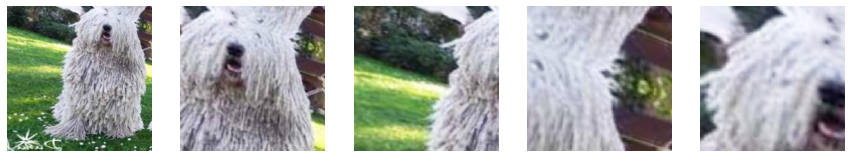

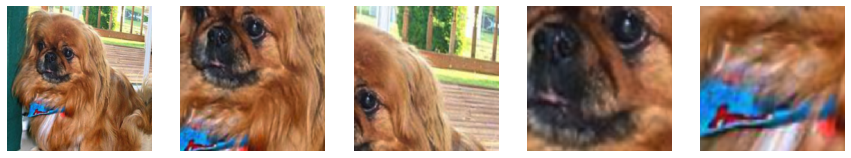

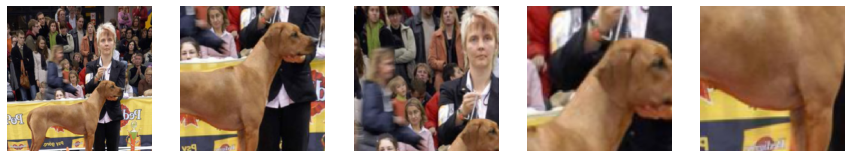

In [63]:
for images in learn.collect_images.images[:5]:
    show_images([dls.after_batch.decode(o[None,...])[0] for o in images])